In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import *
import tensorflow_addons as tfa
tf.__version__

'2.3.0'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Hyperparameters

In [7]:
BEST_PATH = './models/resnet_raw.h5'
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.0015
EPSILON = 1e-08
BATCH_SIZE = 4

# Data loading

In [8]:
l = np.load('./results/2020_W/fw_ct_dataset.npz', allow_pickle=True)
data_indices = l['data_indices']
input_data = l['input_data']
output_label = l['output_label']
INPUT_MAXS = l['INPUT_MAXS']
INPUT_MINS = l['INPUT_MINS']
OUTPUT_MAX = l['OUTPUT_MAX']
OUTPUT_MIN = l['OUTPUT_MIN']

In [9]:
input_data = input_data.astype('float32')
output_label = output_label.astype('float32')

In [10]:
print(input_data.shape)
print(output_label.shape)

(456, 144, 1)
(456, 1)


In [11]:
print(INPUT_MAXS)
print(INPUT_MINS)

[19.731]
[11.000128]


In [12]:
print(OUTPUT_MAX)
print(OUTPUT_MIN)

2.5180414673761202
0.15073025551954564


In [13]:
N_TRAIN = int(input_data.shape[0]*.09)
N_DEV = int(input_data.shape[0]/3)
TRAIN_INDEX = [_ for _ in range(N_TRAIN)] + \
              [_ for _ in range(N_DEV, N_DEV+N_TRAIN)] + \
              [_ for _ in range(N_DEV*2, N_DEV*2+N_TRAIN)]
TEST_INDEX = [_ for _ in range(input_data.shape[0]) if _ not in TRAIN_INDEX]
train_input = input_data[TRAIN_INDEX, ...]
train_label = output_label[TRAIN_INDEX, ...]
train_indices = data_indices[TRAIN_INDEX]
test_input = input_data[TEST_INDEX, ...]
test_label = output_label[TEST_INDEX, ...]
test_indices = data_indices[TEST_INDEX]

In [14]:
train_indices, val_indices, train_input, val_input, train_label, val_label = train_test_split(train_indices, train_input, train_label, test_size=0.3, shuffle=True, random_state=3101)

In [15]:
print(f'number of data set: {input_data.shape[0]}')
print(f'number of training set: {train_input.shape[0]}')
print(f'number of validation set: {val_input.shape[0]}')
print(f'number of test set: {test_input.shape[0]}')

number of data set: 456
number of training set: 86
number of validation set: 37
number of test set: 333


In [16]:
with strategy.scope():
    train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
    train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))
    val_dataset = val_dataset.cache().shuffle(BATCH_SIZE*10).batch(BATCH_SIZE, drop_remainder=False)

# Model construction

In [17]:
class ResidualBlock(layers.Layer):
    def __init__(self, num_filter, stride=1):
        super(ResidualBlock, self).__init__()
        self.n = num_filter
        self.s = stride
        
        self.conv1 = layers.Conv1D(filters=self.n, kernel_size=1, strides=1, kernel_initializer='glorot_normal', padding='same')
        self.norm1 = layers.BatchNormalization()
        self.act1 = layers.Activation(activations.relu)
        self.conv2 = layers.Conv1D(filters=self.n, kernel_size=3, strides=stride, kernel_initializer='glorot_normal', padding='same')
        self.norm2 = layers.BatchNormalization()
        self.act2 = layers.Activation(activations.relu)
        self.conv3 = layers.Conv1D(filters=self.n*4, kernel_size=1, strides=1, kernel_initializer='glorot_normal', padding='same')
        self.norm3 = layers.BatchNormalization()
        self.act3 = layers.Activation(activations.relu)

        self.downsample = Sequential()
        self.downsample.add(layers.Conv1D(filters=self.n*4, kernel_size=1, strides=stride, kernel_initializer='glorot_normal'))
        self.downsample.add(layers.BatchNormalization())

    def call(self, inp, training=None, **kwargs):
        shortcut = self.downsample(inp)

        inp = self.act1(self.norm1(self.conv1(inp), training=training))
        inp = self.act2(self.norm2(self.conv2(inp), training=training))
        inp = self.norm3(self.conv3(inp), training=training)

        oup = self.act3(layers.add([shortcut, inp]))

        return oup

In [18]:
def block_maker(num_filter, num_blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(ResidualBlock(num_filter, stride=stride))

    for _ in range(1, num_blocks):
        res_block.add(ResidualBlock(num_filter, stride=1))

    return res_block

In [19]:
class ResNet1D(Model):
    def __init__(self, layer_params):
        super(ResNet1D, self).__init__()
        self.conv1 = layers.Conv1D(filters=64, kernel_size=7, strides=2, kernel_initializer='glorot_normal', padding="same")
        self.norm1 = layers.BatchNormalization()
        self.act1 = layers.Activation(activations.relu)
        self.pool1 = layers.MaxPool1D(pool_size=3, strides=2, padding="same")

        self.layer1 = block_maker(num_filter=64, num_blocks=layer_params[0])
        self.layer2 = block_maker(num_filter=128, num_blocks=layer_params[1], stride=2)
        self.layer3 = block_maker(num_filter=256, num_blocks=layer_params[2], stride=2)
        self.layer4 = block_maker(num_filter=512, num_blocks=layer_params[3], stride=2)

#         self.avgpool = layers.GlobalAveragePooling1D()
        self.flat = layers.Flatten()
        self.dense1 = layers.Dense(units=512, activation='relu')
        self.dense2 = layers.Dense(units=128, activation='relu')
        self.fc = layers.Dense(units=1)

    def call(self, inp, training=None, mask=None):
        inp = self.conv1(inp)
        inp = self.norm1(inp, training=training)
        inp = self.act1(inp)
        inp = self.pool1(inp)
        inp = self.layer1(inp, training=training)
        inp = self.layer2(inp, training=training)
        inp = self.layer3(inp, training=training)
        inp = self.layer4(inp, training=training)
#         inp = self.avgpool(inp)
        inp = self.dense1(self.flat(inp))
        inp = self.dense2(inp)
        output = self.fc(inp)

        return output

In [20]:
cbs = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=.1, patience=5, verbose=0, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0)

save = callbacks.ModelCheckpoint(
    BEST_PATH, monitor='val_loss', verbose=0,
    save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)

In [21]:
with strategy.scope():
    opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    model = ResNet1D(layer_params=[1, 2, 1, 1])
    model.compile(optimizer=opt, loss='mae')
    model.fit(train_dataset, epochs=TRAINING_EPOCHS, validation_data=val_dataset,
                  verbose=1, callbacks=[cbs, save, early_stop]) 

Epoch 1/200
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
22/22 [==============================] - ETA: 0s - loss: 5.2958INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

In [22]:
model.load_weights(BEST_PATH)

In [23]:
model.evaluate(val_dataset)

10/10 [==============================] - 0s 6ms/step - loss: 0.0652


0.06518778949975967

In [24]:
pred_output = model.predict(test_input)

In [25]:
pred_output = pred_output*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN
test_label = test_label*(OUTPUT_MAX - OUTPUT_MIN) + OUTPUT_MIN

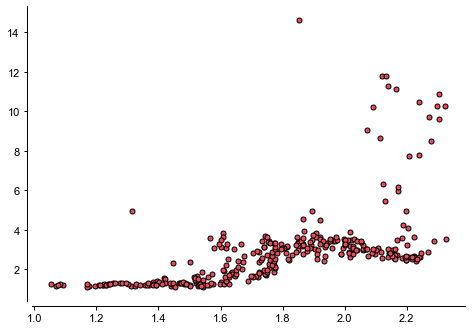

In [26]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(test_label, pred_output, 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [27]:
pred_df = pd.DataFrame(test_label, index=test_indices[:, 0], columns=['label'])
pred_df['pred'] = pred_output

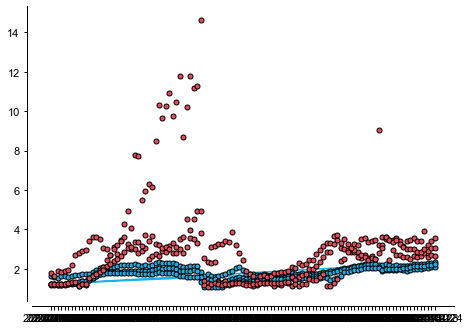

In [28]:
fig = plt.figure(figsize=((8.5/2.54*2), (6/2.54*2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(pred_df.index, pred_df['label'], '-o', ms=5, mec='k', c=cmap[4])
ax0.plot(pred_df.index, pred_df['pred'], 'o', ms=5, mec='k', c=cmap[0])


fig.tight_layout()

In [29]:
pred_df.to_csv('./results/model_output/convnet1d_raw.csv')